## Get the Data

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../content/gdrive/My Drive/Colab Notebooks" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../content/gdrive/My Drive/Colab Notebooks"))

# Any results you write to the current directory are saved as output.

['cifar_img_classification.ipynb', 'MNIST_data', 'mnist_ classification.ipynb', 'cifar-10-batches-py']


In [0]:
# Put file path as a string here
cifar_dir = '../content/gdrive/My Drive/Colab Notebooks/cifar-10-batches-py/'

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.

### Load the Data. Use the Code Below to load the data:

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding = 'bytes')
    return cifar_dict 

In [0]:
dirs = ['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']

In [0]:
all_data = [0,1,2,3,4,5,6]

In [0]:
for i, direc in zip(all_data, dirs):
    all_data[i] = unpickle(cifar_dir + direc)

In [0]:
batch_meta = all_data[0]
batch_1 = all_data[1]
batch_2 = all_data[2]
batch_3 = all_data[3]
batch_4 = all_data[4]
batch_5 = all_data[5]
batch_test = all_data[6]

In [17]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

**Why the 'b's in front of the string?** Bytes literals are always prefixed with 'b' or 'B'; they produce an instance of the bytes type instead of the str type. They may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.

https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal

In [18]:
batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:

*   data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
*   labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:


*   label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Display single image form the dataset
Grab a single image from the batch dataset

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
X = batch_1[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')

In [0]:
random_img = X[np.random.randint(0, 10000)]

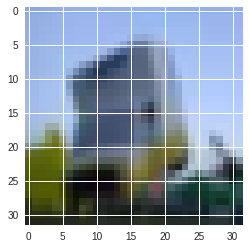

In [22]:
plt.imshow(random_img)

## Helper Functions for Dealing With Data

In [0]:
# function to one-hot encode the labels
def one_hot_encode(vec, vals = 10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
# Cifar helper function includes setting up the training and test images and providing the next batch
class CifarHelper():
    def __init__(self):
        self.i = 0
        
        self.training_set = [batch_1, batch_2, batch_3, batch_4, batch_5]
        
        self.test_set = [batch_test]
        
        self.train_images = None
        self.train_labels = None
        
        self.test_images = None
        self.test_labels = None
        
    def set_images(self):
        # stacking the images vertical
        self.train_images = np.vstack([batch[b'data'] for batch in self.training_set])
        train_len = len(self.train_images)
        
        # reshaping the images in the training set and then transposing it
        self.train_images = self.train_images.reshape(train_len, 3, 32, 32).transpose(0, 2, 3, 1)/255
        
        # one hot encoding the train labels
        self.train_labels = one_hot_encode(np.hstack([batch[b'labels'] for batch in self.training_set]), 10)
        
        # Vertically stacking the test images
        self.test_images = np.vstack([j[b'data'] for j in self.test_set])
        test_len = len(self.test_images)
        
        # Reshaping the test images and then transposing the array
        self.test_images = self.test_images.reshape(test_len, 3, 32, 32).transpose(0, 2, 3, 1)/255
        
        # one hot encoding the test labels
        self.test_labels = one_hot_encode(np.hstack([j[b'labels'] for j in self.test_set]), 10)
        
    def next_batch(self, batch_size):
        x = self.train_images[self.i : self.i + batch_size].reshape(100, 32, 32, 3)
        y = self.train_labels[self.i : self.i + batch_size]
        self.i = (self.i + batch_size) % len(self.train_images)
        return x,y

In [0]:
ch = CifarHelper()

In [0]:
ch.set_images()

##Creating the model

In [0]:
import tensorflow as tf

In [0]:
X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])

In [0]:
y_true = tf.placeholder(tf.float32, shape = [None, 10])

In [0]:
hold_prob = tf.placeholder(tf.float32)

### Helper functions for the model

In [0]:
def init_weights(shape):
    rand_weights = tf.truncated_normal(shape = shape, stddev = 1.0)
    return tf.Variable(rand_weights)

In [0]:
def init_bias(shape):
    bias = tf.constant(0.1, dtype = tf.float32, shape = shape)
    return tf.Variable(bias)

In [0]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

In [0]:
def max_pool_2by2(input_layer):
    return tf.nn.max_pool(input_layer, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

In [0]:
def convolutional_layer(input_X, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_X, W) + b)

In [0]:
def normal_full_layer(input_layer, size):
    shape = input_layer.get_shape().as_list()[1]
    W = init_weights([shape, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [0]:
# starting the model

# 1st convolutional layer
convo_1 = convolutional_layer(X, shape = [4, 4, 3, 32])
convo_1_pooled = max_pool_2by2(convo_1)

In [0]:
# 2nd convolutional layer
convo_2 = convolutional_layer(convo_1_pooled, shape = [4, 4, 32, 64])
convo_2_pooled = max_pool_2by2(convo_2)

In [0]:
# Now comes the falttening layer
convo_2_flat = tf.reshape(convo_2_pooled, [-1, 8*8*64])

In [0]:
# Normal fully connected layer
full_layer = tf.nn.relu(normal_full_layer(convo_2_flat, size = 1024))

In [0]:
# dropout layer
full_drop_layer = tf.nn.dropout(full_layer, keep_prob = hold_prob)

In [0]:
# predicting the labels
y_pred = normal_full_layer(full_drop_layer, size = 10)

In [0]:
# loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits = y_pred))

In [0]:
# setting up the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)

In [0]:
train = optimizer.minimize(cross_entropy)

In [0]:
init = tf.global_variables_initializer()

In [0]:
gpu_options = tf.GPUOptions(allow_growth=True)

In [76]:
# Graph Session

accuracies = []
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for step in range(5000):
        #Training the model
        batch_X, batch_y = ch.next_batch(100)
        sess.run(train, feed_dict = {X : batch_X, y_true: batch_y, hold_prob: 1.0})

        if(step % 100 == 0):
            print('Currently on step: {}'.format(step))
            print('Accuracy :')
            # Testing the model
            equals = [tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1))]
            acc = tf.reduce_mean(tf.cast(equals, dtype = tf.float32))
        
            result= sess.run(acc, feed_dict = {X: ch.test_images, y_true: ch.test_labels, hold_prob: 1.0})
            accuracies.append(result)
            print(result)
            
    avg_accuracy = sum(accuracies)/len(accuracies)
    print('Average Accuracy: {}'.format(avg_accuracy))

Currently on step: 0
Accuracy :
0.1
Currently on step: 100
Accuracy :
0.2305
Currently on step: 200
Accuracy :
0.2736
Currently on step: 300
Accuracy :
0.3101
Currently on step: 400
Accuracy :
0.3251
Currently on step: 500
Accuracy :
0.3459
Currently on step: 600
Accuracy :
0.3421
Currently on step: 700
Accuracy :
0.3501
Currently on step: 800
Accuracy :
0.3694
Currently on step: 900
Accuracy :
0.3791
Currently on step: 1000
Accuracy :
0.3779
Currently on step: 1100
Accuracy :
0.389
Currently on step: 1200
Accuracy :
0.391
Currently on step: 1300
Accuracy :
0.398
Currently on step: 1400
Accuracy :
0.4085
Currently on step: 1500
Accuracy :
0.3985
Currently on step: 1600
Accuracy :
0.4109
Currently on step: 1700
Accuracy :
0.4134
Currently on step: 1800
Accuracy :
0.4238
Currently on step: 1900
Accuracy :
0.4191
Currently on step: 2000
Accuracy :
0.4112
Currently on step: 2100
Accuracy :
0.4233
Currently on step: 2200
Accuracy :
0.4229
Currently on step: 2300
Accuracy :
0.4332
Currently 